<a href="https://colab.research.google.com/github/pranjalsharma/hcai-xai-demos/blob/main/Demo2_BBModel%2BSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demo 2: Black-Box Model + SHAP (Post-hoc XAI)

Models like Random forests or Neural Nets are highly accurate but not interpretable.

We use SHAP (SHapley Additive exPlanations) to explain each feature's contribution to a specific prediction.

In [18]:
!pip install shap scikit-learn pandas seaborn --quiet

In [19]:
import shap
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Load Dataset

In [20]:
titanic = sns.load_dataset('titanic').dropna(subset=['age','fare','sex','class','survived'])
X = pd.get_dummies(titanic[['age','fare','sex','class']], drop_first=True)
y = titanic['survived']

Train/test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Random Forest on this dataset (balck box)

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model trained! Test accuracy:", model.score(X_test, y_test))

Model trained! Test accuracy: 0.7692307692307693


Select a single sample to explain

In [23]:
sample = X_test.iloc[[0]]
print("Sample passenger info:")
display(sample)

Sample passenger info:


,age,fare,sex_male,class_Second,class_Third
149,42.0,13.0,True,True,False


Create SHAP explainer

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(sample)

Extract SHAP values (flattened)

shap_values.vlaues is now an array (1, n_features) for binary classification.

In [27]:
shap_vals = shap_values.values[0, :, 1] # Get SHAP values for the positive class (index 1)
feature_vals = sample.values.flatten()
feature_names = X.columns

Now we build a dataframe

In [28]:
explanation_df = pd.DataFrame({
    'Feature': feature_names,
    'Feature Value': feature_vals,
    'SHAP Value': shap_vals
}).sort_values(by='SHAP Value', ascending=False)

In [29]:
print("\n=== SHAP Explanation ===")
print(f"Predicted Survival: {model.predict(sample)[0]} (1 = survived, 0 = not survived)")
display(explanation_df)


=== SHAP Explanation ===
Predicted Survival: 1 (1 = survived, 0 = not survived)


,Feature,Feature Value,SHAP Value
0,age,42.0,0.156697
1,fare,13.0,0.120965
4,class_Third,False,0.113336
3,class_Second,True,0.041678
2,sex_male,True,-0.181749


/tmp/ipython-input-15872927.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='SHAP Value', data=explanation_df, palette='viridis')


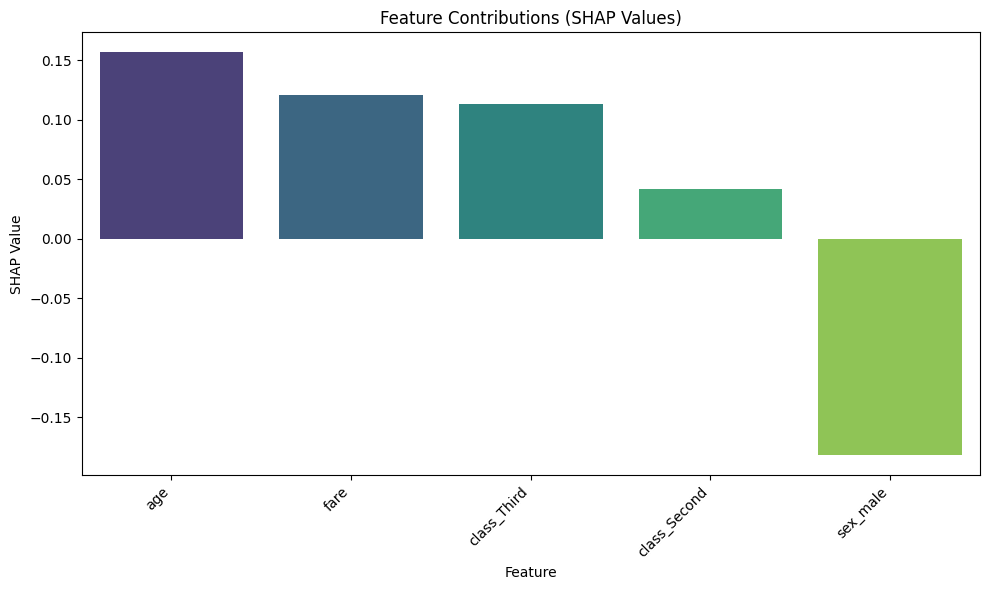

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='SHAP Value', data=explanation_df, palette='viridis')
plt.title('Feature Contributions (SHAP Values)')
plt.xlabel('Feature')
plt.ylabel('SHAP Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Explaining SHAP Values for all Test Samples

To understand the global impact of features, we compute SHAP values for the entire test set and visualize them using a summary plot.

Shape of shap_values_for_summary: (143, 5)
Min SHAP value: -0.2887452371660511
Max SHAP value: 0.50550761509701
Mean SHAP value: -0.00015745101366825316
Std Dev SHAP value: 0.1416743602648988
Absolute max SHAP value: 0.50550761509701


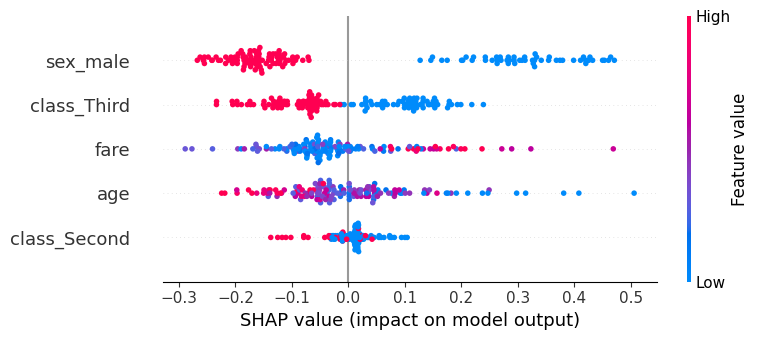

In [41]:
# Calculate SHAP values for the entire test set
shap_values_all = explainer(X_test)

# For binary classification, we often focus on the SHAP values for the positive class (index 1)
# This selects the explanations for the 'survived' class across all test samples.
shap_values_for_summary = shap_values_all[:, :, 1]

# Print statistics to diagnose if values are small
import numpy as np # Ensure numpy is imported for min/max
print("Shape of shap_values_for_summary:", shap_values_for_summary.shape)
print("Min SHAP value:", shap_values_for_summary.values.min())
print("Max SHAP value:", shap_values_for_summary.values.max())
print("Mean SHAP value:", shap_values_for_summary.values.mean())
print("Std Dev SHAP value:", shap_values_for_summary.values.std())
print("Absolute max SHAP value:", np.abs(shap_values_for_summary.values).max())

# Create a summary plot (beeswarm plot)
# Increasing figure size for better visibility
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_for_summary, X_test, feature_names=X_test.columns)